In [1]:
import os 
from Bio import SeqIO
import pickle
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import math

import pandas as pd

from DNA_Encoding import DNA_Encoding

In [2]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 10
shuffle = False
seed = None

expName = "embedReads_setting2_DNAGlobalEncoding"

dataset_path = "CORENup-Datasets\\Datasets"
setting = "Setting2"

outPath = "Generated"
foldName = "folds.pickle"

modelNames = ["RandomForest"]

dataset_setting_path = os.path.join(dataset_path, setting)

obj_DNA_Encoding = DNA_Encoding

In [3]:
##################################################################################
##### define evaluator functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

# def pred2label(y_pred):
#     y_pred = np.round(np.clip(y_pred, 0, 1))
#     return y_pred

In [4]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Model" : [],
    "Kernel_Length" : [],
    "Dataset" : [],
    "Sub_Category" : [],
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

for root, dirs, files in os.walk(dataset_setting_path):
    for file in files:
        if("_vs_" in file):
            
            current_dataset_variety = root.split("\\")[len(root.split("\\"))-2]
            current_dataset_variety_subcategory = root.split("\\")[len(root.split("\\"))-1]
            
            ##################################################################################
            ##### read the current file
            ##################################################################################
            
            openFile = open(os.path.join(root,file))
            fastaSequences = SeqIO.parse(openFile, "fasta")
            
            ##################################################################################
            ##### extract data from the current fasta file
            ##################################################################################
            
            nucleosomal_List = []
            linker_List = []
            nucleosomal_encoded_List = []
            linker_encoded_List = []

            for fasta in fastaSequences: 
                name, sequence = fasta.id, str(fasta.seq)
                if "nucleosomal" in name:
                    nucleosomal_List.append(sequence)
                    aus_seq = DNA_Encoding.GlobalEncoding(self = obj_DNA_Encoding, seq = sequence)
                    if(len(aus_seq) != 0):
                        nucleosomal_encoded_List.append(aus_seq)
                else:
                    linker_List.append(sequence)
                    aus_seq = DNA_Encoding.GlobalEncoding(self = obj_DNA_Encoding, seq = sequence)
                    if(len(aus_seq) != 0):
                        linker_encoded_List.append(aus_seq)
                        
            print("\n======================================================================")
            print("\nFile: "+os.path.join(root, file))
            print("Nucleosomi: "+str(len(nucleosomal_encoded_List)))
            print("Linker: "+str(len(linker_encoded_List)))
            
            ##################################################################################
            ##### Generate Folds from dataset, and store to file
            ##################################################################################
            
            ## create the features and labels datasets for the training
            # input_size = (len(nucleosomal_onehotencoded_List[1]), 4)
            labels = np.concatenate((np.ones((len(nucleosomal_encoded_List), 1), dtype=np.float32), np.zeros((len(linker_encoded_List), 1), dtype=np.float32)), axis=0)
            features = np.concatenate((nucleosomal_encoded_List,linker_encoded_List), 0)

            ## Generate the k-fold dataset
            folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)
            
            ## Write the k-fold dataset to file
            foldPath = os.path.join(outPath, expName, current_dataset_variety, current_dataset_variety_subcategory, "{}fold".format(n_fold))
            if(not os.path.isdir(foldPath)):
                os.makedirs(foldPath)
            pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))
            
            ##################################################################################
            ##### TRAIN and PREDICT for every Fold, using both models (DLNN3 and DLNN5)
            ##################################################################################

            for modelName in modelNames:

                # kernel_length = int(modelName[-1])

                ## Create and set directory to save model
                modelPath = os.path.join(outPath, expName, current_dataset_variety, current_dataset_variety_subcategory, "{}fold".format(n_fold), "models", modelName)
                if(not os.path.isdir(modelPath)):
                    os.makedirs(modelPath)

                # fold counter
                i = 0

                for fold in folds:

                    print("\nTrain/Test model "+modelName+" on Fold #"+str(i)+".")

                    ## Generate model Random Forest
                    model = RandomForestClassifier(n_estimators = 100, random_state = 42, oob_score = True, criterion = "gini")

                    model.fit(X = fold["X_train"], 
                              y = fold["y_train"].reshape(fold["y_train"].shape[0]))

                    pickle.dump(model, open(os.path.join(modelPath, "{}_bestModel-fold{}.pkl".format(modelName, i)), 'wb'))

                    ##################################################################################
                    ##### Prediction and metrics for TRAIN dataset
                    ##################################################################################

                    y_pred = model.predict(fold["X_train"])
                    # label_pred = pred2label(y_pred)
                    label_pred = y_pred
                    # Compute precision, recall, sensitivity, specifity, mcc
                    acc = accuracy_score(fold["y_train"], label_pred)
                    prec = precision_score(fold["y_train"],label_pred)

                    conf = confusion_matrix(fold["y_train"], label_pred)
                    if(conf[0][0]+conf[1][0]):
                        sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                    else:
                        sens = 0.0
                    if(conf[1][1]+conf[0][1]):
                        spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                    else:
                        spec = 0.0
                    if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                        mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                    else:
                        mcc= 0.0
                    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
                    auc = roc_auc_score(fold["y_train"], y_pred)

                    evaluations["Model"].append(modelName)
                    evaluations["Kernel_Length"].append("")
                    evaluations["Dataset"].append(current_dataset_variety)
                    evaluations["Sub_Category"].append(current_dataset_variety_subcategory)
                    evaluations["Fold"].append(i)
                    evaluations["Train_Test"].append("Train")
                    evaluations["Accuracy"].append(acc)
                    evaluations["Precision"].append(prec)
                    evaluations["TPR"].append(tpr)
                    evaluations["FPR"].append(fpr)
                    evaluations["TPR_FPR_Thresholds"].append(thresholds)
                    evaluations["AUC"].append(auc)
                    evaluations["Sensitivity"].append(sens)
                    evaluations["Specificity"].append(spec)
                    evaluations["MCC"].append(mcc)

                    ##################################################################################
                    ##### Prediction and metrics for TEST dataset
                    ##################################################################################

                    y_pred = model.predict(fold["X_test"])
                    # label_pred = pred2label(y_pred)
                    label_pred = y_pred
                    # Compute precision, recall, sensitivity, specifity, mcc
                    acc = accuracy_score(fold["y_test"], label_pred)
                    prec = precision_score(fold["y_test"],label_pred)

                    conf = confusion_matrix(fold["y_test"], label_pred)
                    if(conf[0][0]+conf[1][0]):
                        sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                    else:
                        sens = 0.0
                    if(conf[1][1]+conf[0][1]):
                        spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                    else:
                        spec = 0.0
                    if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                        mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                    else:
                        mcc= 0.0
                    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
                    auc = roc_auc_score(fold["y_test"], y_pred)

                    evaluations["Model"].append(modelName)
                    evaluations["Kernel_Length"].append("")
                    evaluations["Dataset"].append(current_dataset_variety)
                    evaluations["Sub_Category"].append(current_dataset_variety_subcategory)
                    evaluations["Fold"].append(i)
                    evaluations["Train_Test"].append("Test")
                    evaluations["Accuracy"].append(acc)
                    evaluations["Precision"].append(prec)
                    evaluations["TPR"].append(tpr)
                    evaluations["FPR"].append(fpr)
                    evaluations["TPR_FPR_Thresholds"].append(thresholds)
                    evaluations["AUC"].append(auc)
                    evaluations["Sensitivity"].append(sens)
                    evaluations["Specificity"].append(spec)
                    evaluations["MCC"].append(mcc)

                    i = i+1
                    del model

##################################################################################
##### Dump evaluations to a file
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

pickle.dump(evaluations,
            open(os.path.join(evalPath, "{}fold_evaluations.pickle".format(n_fold)), "wb"))




File: CORENup-Datasets\Datasets\Setting2\Drosophila\5UTR\nucleosomes_vs_linkers_drosophila_5u.fas
Nucleosomi: 4669
Linker: 2704

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model RandomForest on Fold #5.

Train/Test model RandomForest on Fold #6.

Train/Test model RandomForest on Fold #7.

Train/Test model RandomForest on Fold #8.

Train/Test model RandomForest on Fold #9.


File: CORENup-Datasets\Datasets\Setting2\Drosophila\Longest_chr\nucleosomes_vs_linkers_drosophila_lc.fas
Nucleosomi: 46054
Linker: 30458

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model RandomForest on Fold #5.

Train/Test model RandomForest on Fold #6.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model RandomForest on Fold #1.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model RandomForest on Fold #2.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model RandomForest on Fold #3.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model RandomForest on Fold #4.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model RandomForest on Fold #5.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model RandomForest on Fold #6.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model RandomForest on Fold #7.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model RandomForest on Fold #8.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in longlong_scalars



Train/Test model RandomForest on Fold #9.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in longlong_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: overflow encountered in longlong_scalars




File: CORENup-Datasets\Datasets\Setting2\Homo_Sapiens\Promoter\nucleosomes_vs_linkers_human_prom.fas
Nucleosomi: 56404
Linker: 44639

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model RandomForest on Fold #5.

Train/Test model RandomForest on Fold #6.

Train/Test model RandomForest on Fold #7.

Train/Test model RandomForest on Fold #8.

Train/Test model RandomForest on Fold #9.


File: CORENup-Datasets\Datasets\Setting2\Yeast\Promoter\nucleosomes_vs_linkers_yeast_prom.fas
Nucleosomi: 27373
Linker: 4463

Train/Test model RandomForest on Fold #0.

Train/Test model RandomForest on Fold #1.

Train/Test model RandomForest on Fold #2.

Train/Test model RandomForest on Fold #3.

Train/Test model RandomForest on Fold #4.

Train/Test model RandomForest on Fold #5.

Train/Test model RandomForest on Fold #6.

Train/

## Visualization of Evaluation

In [5]:
##################################################################################
##### Add import statement here, to make this next part of code standalone executable
##################################################################################

import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import numpy as np
import pandas as pd
import math


In [6]:
##################################################################################
##### Parameters used only in this section
##################################################################################

n_fold = 10
expName = "embedReads_setting2_DNAGlobalEncoding"
outPath = "Generated"

modelNames = ["RandomForest"]

In [9]:
##################################################################################
##### Load file and convert to dataframe for easy manipulation
##################################################################################

evalPath = os.path.join(outPath, expName, "_Evaluation_All_Datasets")
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

evaluations = pickle.load(open(os.path.join(evalPath, "{}fold_evaluations.pickle".format(n_fold)), "rb"))

evaluations_df = pd.DataFrame.from_dict(evaluations)

In [27]:
##################################################################################
##### Group dataset (mean of metrics) by [Dataset, Model, Train_Test] combinations
##################################################################################

evaluations_df_grouped = evaluations_df.groupby(["Dataset",
                                                 "Sub_Category",
                                                 "Model", 
                                                 "Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

RF_Train = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(3), ['Train'])]
RF_Test = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(3), ['Test'])]

In [28]:
##################################################################################
##### Decide on metric to visualize
##################################################################################

print("Metrics Available : ")
print(list(evaluations_df_grouped.columns))

Metrics Available : 
['Accuracy', 'Precision', 'AUC', 'Sensitivity', 'Specificity', 'MCC']


#### Select a metric to plot below:

In [29]:
metric_to_plot = "Accuracy"

In [32]:
a = list(np.unique(RF_Train.index.get_level_values(2)))
a

['RandomForest']

In [33]:
# Filter_df  = DLNN_Train[DLNN_Train.index.isin(a)]
RF_Train[RF_Train.index.get_level_values('Model').isin([a[0]])]

Accuracy  Precision  \
Dataset      Sub_Category Model        Train_Test                        
Drosophila   5UTR         RandomForest Train       0.999593   0.999358   
             Longest_chr  RandomForest Train       0.987075   0.979007   
             Promoter     RandomForest Train       0.994652   0.991536   
Homo_Sapiens 5UTR         RandomForest Train       0.962540   0.999761   
             Longest_chr  RandomForest Train       0.921762   0.997999   
             Promoter     RandomForest Train       0.943432   0.999321   
Yeast        Promoter     RandomForest Train       0.999997   0.999996   
             Whole_genome RandomForest Train       1.000000   1.000000   

                                                        AUC  Sensitivity  \
Dataset      Sub_Category Model        Train_Test                          
Drosophila   5UTR         RandomForest Train       0.999445     1.000000   
             Longest_chr  RandomForest Train       0.983774     0.999955   
             Promoter     RandomForest Train       0.992840     1.000000   
Homo_Sapiens 5UTR         RandomForest Train       0.973344     0.887061   
             Longest_chr  RandomForest Train       0.934076     0.838835   
             Promoter     RandomForest Train       0.949251     0.887022   
Yeast        Promoter     RandomForest Train       0.999988     1.000000   
             Whole_genome RandomForest Train       1.000000     1.000000   

                                                   Specificity       MCC  
Dataset      Sub_Category Model        Train_Test                         
Drosophila   5UTR         RandomForest Train          0.999358  0.999124  
             Longest_chr  RandomForest Train          0.979007  0.973238  
             Promoter     RandomForest Train          0.991536  0.988604  
Homo_Sapiens 5UTR         RandomForest Train          0.999761  0.916266  
             Longest_chr  RandomForest Train          0.997999  1.477518  
             Promoter     RandomForest Train          0.999321  0.892402  
Yeast        Promoter     RandomForest Train          0.999996  0.999986  
             Whole_genome RandomForest Train          1.000000  1.000000

In [34]:
# Filter_df  = DLNN_Train[DLNN_Train.index.isin(a)]
RF_Test[RF_Test.index.get_level_values('Model').isin([a[0]])]

Accuracy  Precision  \
Dataset      Sub_Category Model        Train_Test                        
Drosophila   5UTR         RandomForest Test        0.695920   0.706642   
             Longest_chr  RandomForest Test        0.707536   0.703835   
             Promoter     RandomForest Test        0.734529   0.733547   
Homo_Sapiens 5UTR         RandomForest Test        0.771638   0.796691   
             Longest_chr  RandomForest Test        0.810735   0.850346   
             Promoter     RandomForest Test        0.774036   0.780061   
Yeast        Promoter     RandomForest Test        0.892606   0.898216   
             Whole_genome RandomForest Test        0.911656   0.916699   

                                                        AUC  Sensitivity  \
Dataset      Sub_Category Model        Train_Test                          
Drosophila   5UTR         RandomForest Test        0.625740     0.654640   
             Longest_chr  RandomForest Test        0.661242     0.720988   
             Promoter     RandomForest Test        0.676659     0.739155   
Homo_Sapiens 5UTR         RandomForest Test        0.674144     0.667156   
             Longest_chr  RandomForest Test        0.804235     0.762670   
             Promoter     RandomForest Test        0.766111     0.767443   
Yeast        Promoter     RandomForest Test        0.650339     0.792215   
             Whole_genome RandomForest Test        0.625253     0.775373   

                                                   Specificity       MCC  
Dataset      Sub_Category Model        Train_Test                         
Drosophila   5UTR         RandomForest Test           0.706642  0.301318  
             Longest_chr  RandomForest Test           0.703835  0.369915  
             Promoter     RandomForest Test           0.733547  0.408560  
Homo_Sapiens 5UTR         RandomForest Test           0.796691  0.401515  
             Longest_chr  RandomForest Test           0.850346  0.610533  
             Promoter     RandomForest Test           0.780061  0.539748  
Yeast        Promoter     RandomForest Test           0.898216  0.455010  
             Whole_genome RandomForest Test           0.916699  0.415963

In [35]:
model_list = list(np.unique(RF_Train.index.get_level_values(1)))
model_list

['5UTR', 'Longest_chr', 'Promoter', 'Whole_genome']

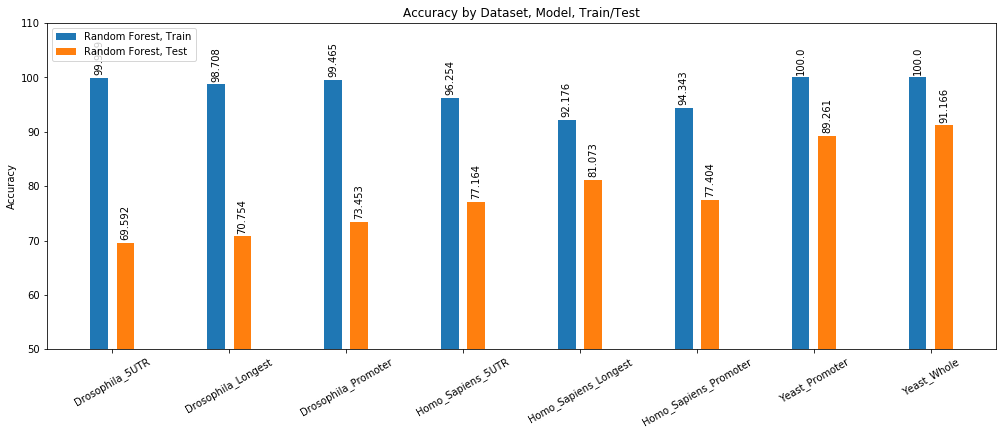

In [38]:
##################################################################################
##### Visualize with a multiple Bar chart
##################################################################################

x = np.arange(len(RF_Train[metric_to_plot]))
width = 0.15

fig, ax = plt.subplots(figsize=(17,6))
rects1 = ax.bar(x - (1.5*(width/2)), round(RF_Train[metric_to_plot]*100, 3), width, label='Random Forest, Train')
rects3 = ax.bar(x + (1.5*(width/2)), round(RF_Test[metric_to_plot]*100, 3), width, label='Random Forest, Test')

## Custom y-axis tick labels
ax.set_ylabel(metric_to_plot)
ax.set_ylim([max((math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 0), 
            max((math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10, 0)])
# ax.set_ylim([80, 105])

## Custom x-axis tick labels
ax.set_xticks(x)
#ax.set_xticklabels(RF_Train.index.get_level_values(0))
# ax.set_xticklabels([m+" - "+str(n) for m,n in 
#                         zip(DLNN_CORENup_Train.index.get_level_values(0),DLNN_CORENup_Train.index.get_level_values(1))],
#                   rotation=30)
ax.set_xticklabels([a + "_" + b.split("_")[0] for a, b in zip(RF_Train.index.get_level_values(0), RF_Train.index.get_level_values(1))],
                   rotation=30)


ax.set_title(metric_to_plot+' by Dataset, Model, Train/Test')
ax.legend(loc='upper left')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='center', va='bottom', rotation=90)

autolabel(rects1)
autolabel(rects3)

plt.show()

### Store all metrics' plots to file

In [39]:
##################################################################################
##### Iteratively generate comparison plot using every metric
##################################################################################

for metric_to_plot in list(evaluations_df_grouped.columns):
    
    x = np.arange(len(RF_Train[metric_to_plot]))
    width = 0.15

    fig, ax = plt.subplots(figsize=(17,6))
    rects1 = ax.bar(x - (1.5*(width/2)), round(RF_Train[metric_to_plot]*100, 3), width, label='Random Forest, Train')
    rects3 = ax.bar(x + (1.5*(width/2)), round(RF_Test[metric_to_plot]*100, 3), width, label='Random Forest, Test')

    ## Custom y-axis tick labels
    ax.set_ylabel(metric_to_plot)
    ax.set_ylim([max((math.floor(min(evaluations_df_grouped[metric_to_plot])*10)-1)*10, 0), 
                max((math.ceil(max(evaluations_df_grouped[metric_to_plot])*10)+1)*10, 0)])
    # ax.set_ylim([80, 105])

    ## Custom x-axis tick labels
    ax.set_xticks(x)
    #ax.set_xticklabels(RF_Train.index.get_level_values(0))
    # ax.set_xticklabels([m+" - "+str(n) for m,n in 
    #                         zip(DLNN_CORENup_Train.index.get_level_values(0),DLNN_CORENup_Train.index.get_level_values(1))],
    #                   rotation=30)
    ax.set_xticklabels([a + "_" + b.split("_")[0] for a, b in zip(RF_Train.index.get_level_values(0), RF_Train.index.get_level_values(1))],
                       rotation=30)


    ax.set_title(metric_to_plot+' by Dataset, Model, Train/Test')
    ax.legend(loc='upper left')

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", 
                        ha='center', va='bottom', rotation=90)

    autolabel(rects1)
    autolabel(rects3)
    
    plt.savefig(os.path.join(evalPath, "{}_{}_Comparison".format(metric_to_plot, modelNames[0].format("all"))))
    plt.close()
    